# Business context

Metaloop is a metal recycling company based in Graz, Austria. We operate as a digital scrap-yard, which means we don't own or lease any warehouses where we store material. Instead, we do the matching of suppliers (also called "sellers") and buyers online, through a managed marketplace

One of our main sources of inbound marketing is a form that is available in our website. It's called internally "Pro-form", and it's the form filled our by enterprise customers to sell a specified quantity of scrap metal

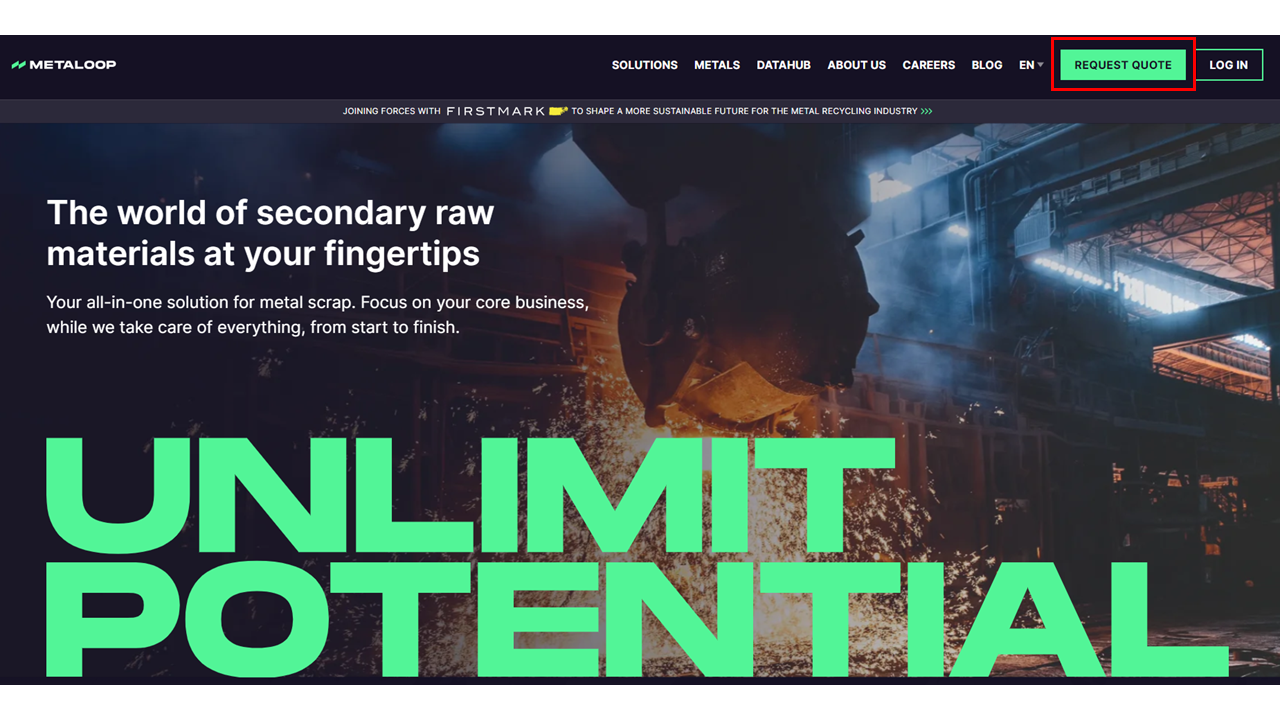

In our home-page, you can see the path to the Pro-form on the top right. After clicking it, the prospects are redirected to an online form with several questions

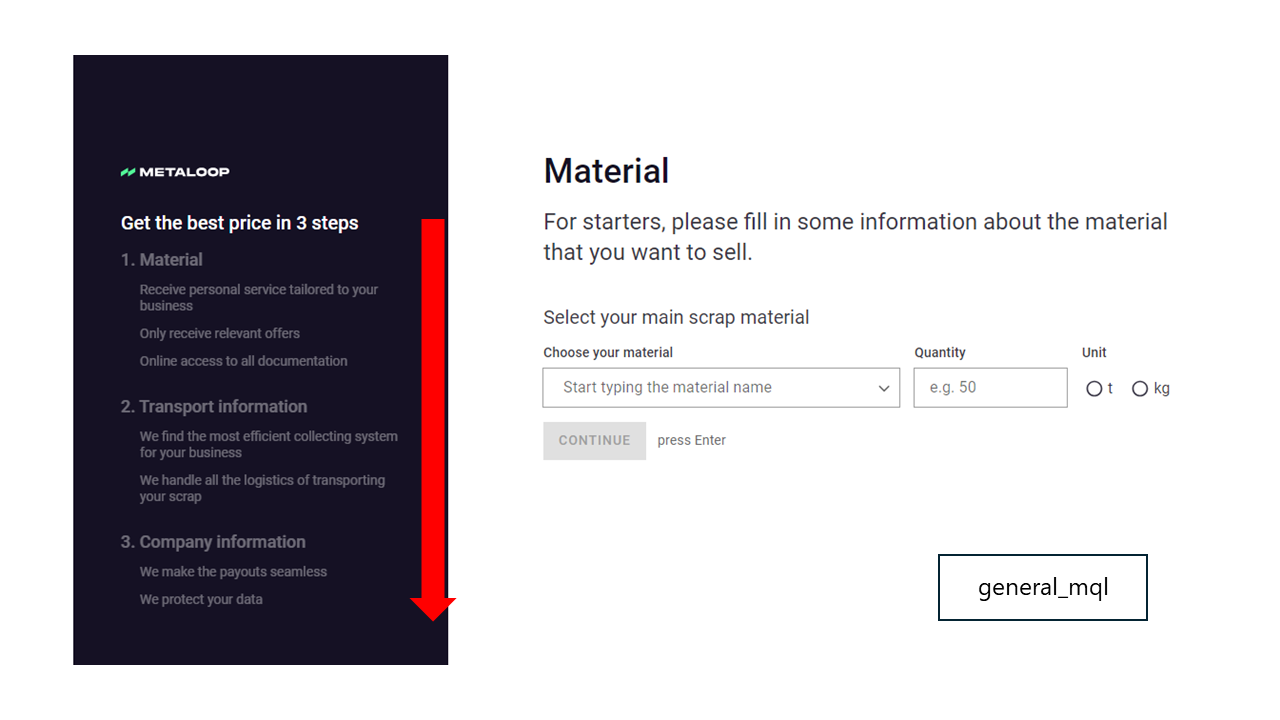

After completing this form, an opportunity record is created on our CRM system and the sales department takes it from there. We do not directly sell anything from the website for wholesale customer, our deals are of high involvement and the sales team always needs to qualify and follow up. Therefore, our most important conversion in the website is the completion of this form.

The completion of this form is tracked in the Google Analytics suite via the tag manager. The event that records the submission of the pro-form is called "general-mql". Due to the fact that no sale occurs on the website, Google analytics can't calculate ROI or LTV out of the box. Another limiting factor to analysis is the long sale cycle. Generally, from a new prospect to a first order delivered, when we realize the revenue, we will take at least 45 days.  

Our goal here is to assess and the effectiveness of our SAE efforts on the webpage, and decide on future steps

## Initial analysis

Before looking into the specific conversion of the campaigns, we will analyse the effectiveness of the inbound channel as a whole. As mentioned above, all of the opportunities created from the pro-form generate an opportunity in our CRM with the flag "from pro form". There are other sources of inbound traffic in our company, mainly in people calling up our sales people directly. However, this is not consistently tracked and represents a small proportion of the volume. Furthermore, for most cases (i.e: existing customers) these are not dependent on the SAE efforts, which is the focus of this study.


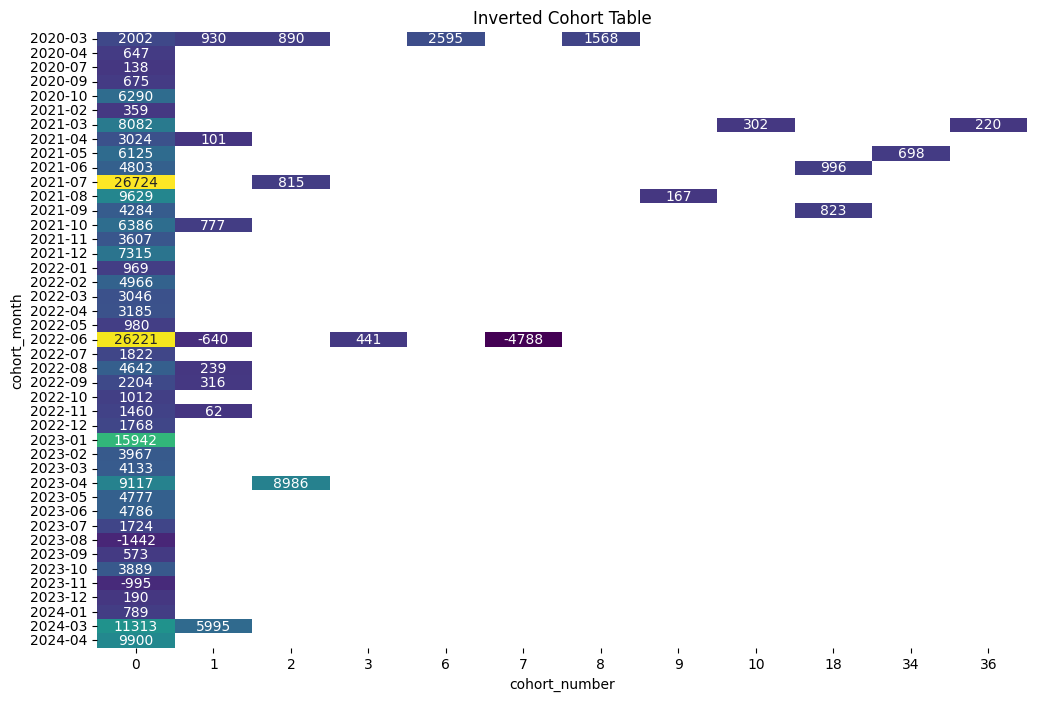

In [2]:
import pandas as pd
inbound_orders = pd.read_csv('data/inbound_orders_2024_04_04.csv')

# Transform date types
inbound_orders['order_date'] = pd.to_datetime(inbound_orders['dt_checkout_date'], format='%Y-%m-%d')
inbound_orders['cohort'] = pd.to_datetime(inbound_orders['cohort'], format='%Y-%m-%d')

# Get month difference betwee checkout date and cohort

inbound_orders['cohort_number'] = (inbound_orders['order_date'].dt.year - inbound_orders['cohort'].dt.year) * 12 \
                                 + (inbound_orders['order_date'].dt.month - inbound_orders['cohort'].dt.month)


inbound_orders['cohort_month'] = inbound_orders['cohort'].dt.to_period('M')
# Plot inverted cohort table with color coding

import seaborn as sns
import matplotlib.pyplot as plt

# Create the pivot table

cohort_table = inbound_orders.pivot_table(index='cohort_month', columns='cohort_number', values='adjusted_contribution_margin', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, cmap='viridis', annot=True, fmt='.0f', cbar=False)

plt.title('Inverted Cohort Table')

plt.show()

Importing all of the opportunties. The following query was run in our warehouse (for reproducibility)

select 
    * 
from prd.silver.stg_salesforce__opportunity
where 
-- REMOVING THE FAKE LEADS
(ds_loss_reason != 'fake' or ds_loss_reason is null)
and 
-- LIMITING THE SCOPE TO 2023
ts_created_at >= '2023-01-01'
-- KEEP ONLY THE RTS OPP type
and
fk_record_type = '01209000000xizdAAA'



In [7]:
all_opportunities = pd.read_csv('data/all_opportunities.csv')

all_opportunities.head()


,pk_opportunity,ds_stage_name,ds_type,ds_lead_source,ds_forecast_category,ds_forecast_category_name,ds_loss_reason,ds_transport_type,ds_contract_type,txt_description,...,dco_Related_Contract_Role__c,dco_DB_Competitor__c,dco_Transport_solution__c,dco_oppSource__c,dco_Contract_Incoterms__c,dco_Contract_Origin_Country__c,dco_Contract_Shipping_Period__c,dco_Opportunity_Frequency__c,dco_Fiscal,dco_Channel__c
0,0069N000002Tv8QQAS,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0069N000002U9AmQAK,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0069N000002UCOqQAO,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0069N000002UDKvQAO,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0069N000002UDXfQAO,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are several historical and operational reasons why the values stored in the opportunities object (in terms of estimated GMV and margin) are absiolutely incomplete and not realible. Therefore, we need to use the order objects that are linked to the opportunities in order to get a sense for the revenue and margin generated from these opportunities. It's also worth noting that many of our orders go through an intermediary warehouse before being delivered to the final buyer. When this is the case, we create multiple orders to represent each leg of the journey. Therefore, since we are only interested in the seller (i.e: acquisition) side of the deals, we must keep only the loads that represent the direct transport (called "Mixed") and the ones representing the first leg (i.e: From the seller, called "Acquisition")


In [55]:
all_orders = pd.read_csv('data/all_orders.csv')

# Because we are only interested in the Seller side, we need to remove all loads that are liquidation or stock trasnfer

all_orders = all_orders[~all_orders['ds_type_of_load'].isin(['Liquidation', 'Stock Transfer'])]

all_orders['dt_checkout_date'] = pd.to_datetime(all_orders['dt_checkout_date'], format='%Y-%m-%d')

all_orders['cohort'] = pd.to_datetime(all_orders['cohort'], format='%Y-%m-%d')

all_orders['from_opp'] = ~all_orders['fk_opportunity'].isna()


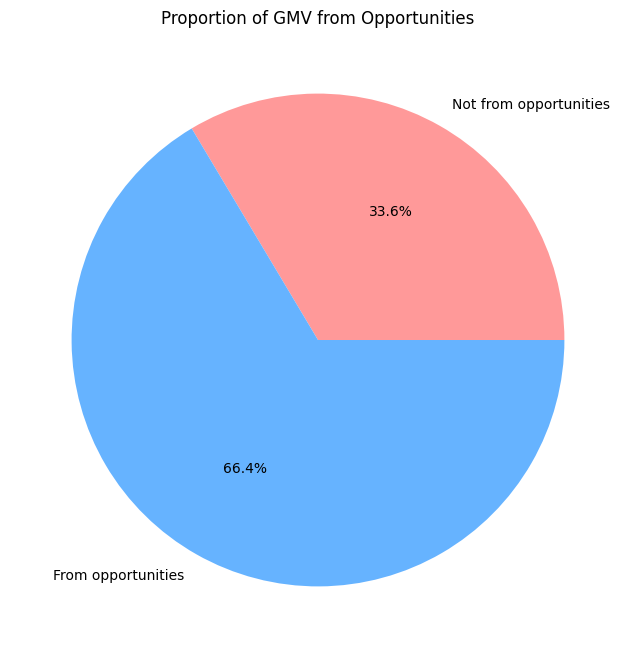

In [56]:
# Plot proportion of gmv from opportunities from the total
gmv_from_opportunities = all_orders.groupby('from_opp')['adjusted_gmv'].sum()
plt.figure(figsize=(8, 8))

plt.pie(gmv_from_opportunities, labels=['Not from opportunities', 'From opportunities'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Proportion of GMV from Opportunities')
plt.show()


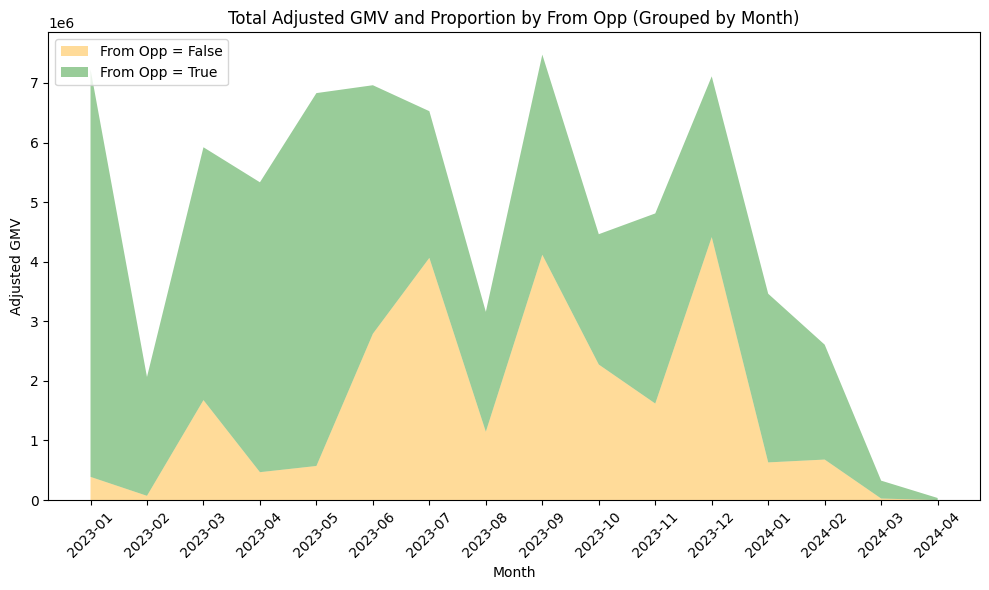

In [57]:
# Group by month and sum the adjusted_gmv for each month
total_gmv = all_orders.groupby(all_orders['dt_checkout_date'].dt.to_period('M'))['adjusted_gmv'].sum()

# Group by month, checkout_date, and from_opp, then calculate the sum of adjusted_gmv for each group
grouped_gmv = all_orders.groupby([all_orders['dt_checkout_date'].dt.to_period('M'), 'from_opp'])['adjusted_gmv'].sum().unstack(fill_value=0)

# Calculate the proportion of adjusted_gmv for from_opp = True and False
proportion_from_opp_true = grouped_gmv[True] / total_gmv
proportion_from_opp_false = grouped_gmv[False] / total_gmv

# Plotting
plt.figure(figsize=(10, 6))

# Plot stacked area chart
plt.stackplot(total_gmv.index.astype(str),
              [grouped_gmv[False], grouped_gmv[True]],
              labels=['From Opp = False', 'From Opp = True'],
              colors=['orange', 'green'], alpha=0.4)

# Customize plot
plt.xlabel('Month')
plt.ylabel('Adjusted GMV')
plt.title('Total Adjusted GMV and Proportion by From Opp (Grouped by Month)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

Now we add the context of whether or not the opportunity that originated that order came from the pro form

In [58]:
# merge all_orders with all_opportunities
all_orders = all_orders.merge(all_opportunities[['pk_opportunity', 'flg_is_from_pro_form']], how='left', left_on='fk_opportunity', right_on='pk_opportunity')

# Fill the missing values in the flg_is_from_pro_form column with False
all_orders['flg_is_from_pro_form'] = all_orders['flg_is_from_pro_form'].fillna(False)

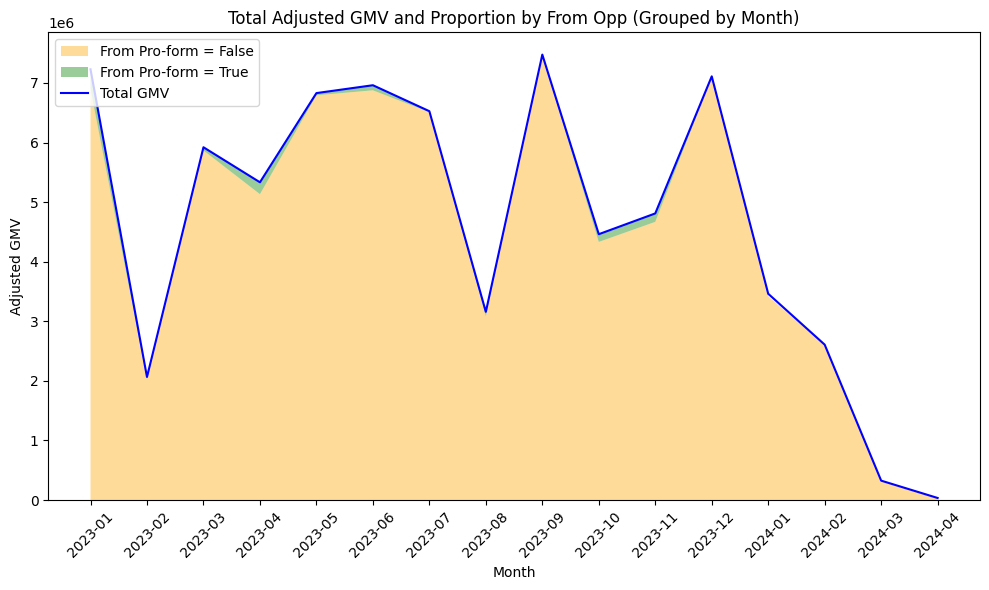

In [60]:
# Group by month and sum the adjusted_gmv for each month
total_gmv = all_orders.groupby(all_orders['dt_checkout_date'].dt.to_period('M'))['adjusted_gmv'].sum()

# Group by month, checkout_date, and from_opp, then calculate the sum of adjusted_gmv for each group
grouped_gmv = all_orders.groupby([all_orders['dt_checkout_date'].dt.to_period('M'), 'flg_is_from_pro_form'])['adjusted_gmv'].sum().unstack()

# Calculate the proportion of adjusted_gmv for from_opp = True and False
proportion_from_opp_true = grouped_gmv[True] / total_gmv
proportion_from_opp_false = grouped_gmv[False] / total_gmv

# Plotting
plt.figure(figsize=(10, 6))

# Plot stacked area chart
plt.stackplot(total_gmv.index.astype(str),
              [grouped_gmv[False], grouped_gmv[True]],
              labels=['From Pro-form = False', 'From Pro-form = True'],
              colors=['orange', 'green'], alpha=0.4)

# Plot total adjusted GMV line
plt.plot(total_gmv.index.astype(str), total_gmv, color='blue', label='Total GMV')

# Customize plot
plt.xlabel('Month')
plt.ylabel('Adjusted GMV')
plt.title('Total Adjusted GMV and Proportion by From Opp (Grouped by Month)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_17111/1497424119.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=all_orders, x='flg_is_from_pro_form', y='adjusted_gmv', palette='viridis', jitter=True, alpha=0.8)


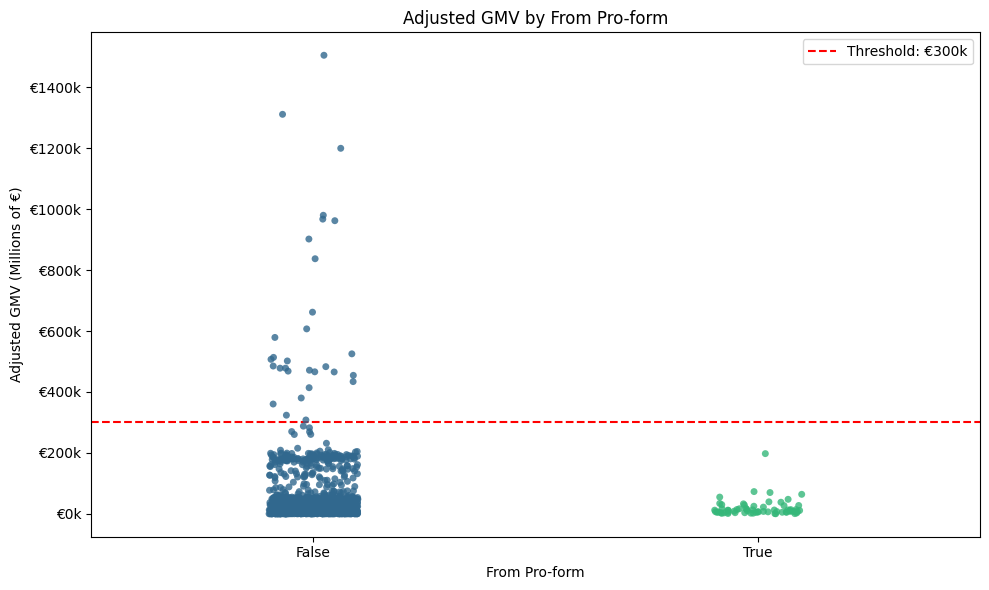

In [76]:
import matplotlib.ticker as ticker

# Assuming all_orders is your DataFrame with columns flg_is_from_pro_form and adjusted_gmv
# If not, replace all_orders with your DataFrame name

plt.figure(figsize=(10, 6))

# Strip plot of adjusted_gmv by flg_is_from_pro_form
sns.stripplot(data=all_orders, x='flg_is_from_pro_form', y='adjusted_gmv', palette='viridis', jitter=True, alpha=0.8)

# Customize plot
plt.xlabel('From Pro-form')
plt.ylabel('Adjusted GMV (Millions of €)')
plt.title('Adjusted GMV by From Pro-form')

# Format y-axis ticks as millions of euros with euro sign
formatter = ticker.FuncFormatter(lambda x, pos: f'€{x / 1000:.0f}k')
plt.gca().yaxis.set_major_formatter(formatter)

# Plot horizontal line at 300,000 euros
plt.axhline(y=300000, color='red', linestyle='--', label='Threshold: €300k')

# Show plot
plt.legend()
plt.tight_layout()
plt.show()



In [81]:
# Get largest order from pro-form

largest_order_pro_form = all_orders[all_orders['flg_is_from_pro_form']].nlargest(10, 'adjusted_gmv')

largest_order_pro_form

,pk_order,fk_seller,fk_opportunity,dt_checkout_date,cohort,ds_type_of_load,adjusted_gmv,adjusted_net_revenue,adjusted_contribution_margin,from_opp,pk_opportunity,flg_is_from_pro_form
107,a0b9N000000IxKiQAK,0019N000003jRSHQA2,0069N000002VUDWQA4,2023-01-12,2023-01-12,Acquisition,197577.60,5613.00,4963.00,True,0069N000002VUDWQA4,True
969,a0b9N000000NIoYQAW,00109000009gpIBAAY,0069N000002iQTYQA2,2023-04-04,2023-04-04,Mixed,72926.60,1446.00,646.00,True,0069N000002iQTYQA2,True
1213,a0b9N000000ZNzjQAG,0019N000005MpqyQAC,0069N000003CO8WQAW,2023-11-09,2023-11-09,Acquisition,69834.80,694.40,-5846.15,True,0069N000003CO8WQAW,True
696,a0b9N000000OIcXQAW,0019N000004SQNtQAO,0069N000002kudxQAA,2023-04-27,2023-04-27,Mixed,63956.45,4921.82,1021.82,True,0069N000002kudxQAA,True
113,a0b9N000000JLuwQAG,0019N000003qPBeQAM,0069N000002XgV4QAK,2023-01-25,2023-01-25,Mixed,54835.20,2846.08,1338.30,True,0069N000002XgV4QAK,True
527,a0b9N000000UGSbQAO,0019N000005Ib3mQAC,0069N0000039g2TQAQ,2023-10-05,2023-10-05,Acquisition,47574.60,1500.10,950.10,True,0069N0000039g2TQAQ,True
189,a0b9N000000JL8aQAG,0019N000003qY6DQAU,0069N000002Wn9oQAC,2023-01-24,2023-01-24,Mixed,39258.14,4830.19,4230.19,True,0069N000002Wn9oQAC,True
258,a0b9N000000YwspQAC,00109000009gn2dAAA,0069N000002VUDWQA4,2023-11-07,2023-11-07,Mixed,37953.20,1707.10,257.10,True,0069N000002VUDWQA4,True
937,a0b9N000000dM3kQAE,0019N00000690F0QAI,0069N000003WDLVQA4,2024-01-31,2024-01-31,Mixed,33947.92,1976.42,1126.42,True,0069N000003WDLVQA4,True
35,a0b9N000000QC9dQAG,0019N0000047dmLQAQ,0069N000002dYm6QAE,2023-06-14,2023-04-21,Mixed,32625.00,15486.00,8986.00,True,0069N000002dYm6QAE,True


The largest order from Pro-form is around 40 mt of Brass, with an estimated contribution margin of 5k. The top 10 orders from the pro-form amount to 17.6k eur.

We know that this is a somewhat limiting approach (only looking at the opportunity level). Because accounts could have started from the pro-form, but developed into a recurring customer.

Our first approach will be to look at all sellers that interacted with the pro-form, and mark those as "inbound sellers"

---

Define an inbound account as an account where its first **created** order came from inbound (i.e: associated with an opp with the flag is from pro form)

Potential limitations

1. Maybe the first order was a test, maybe if failed from another source and then the account came back some time later. We will simply ignore these cases



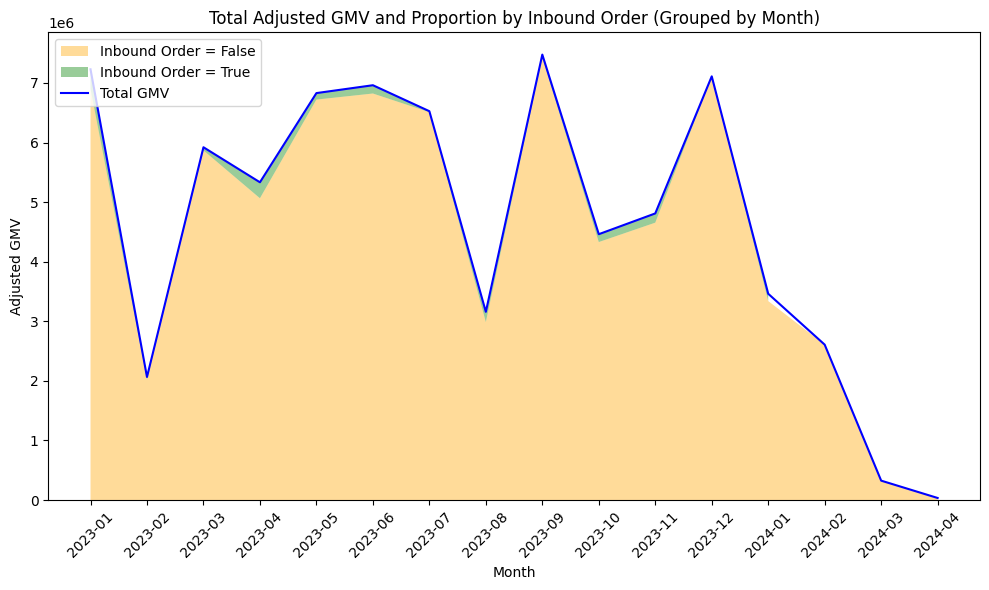

In [82]:
# List all fk_seller that have an order from pro-form

sellers_with_pro_form = all_orders[all_orders['flg_is_from_pro_form']]['fk_seller'].unique()

# Flag orders as inbound orders if the fk_seller is in sellers_with_pro_form

all_orders['inbound_order'] = all_orders['fk_seller'].isin(sellers_with_pro_form)

# Group by month and sum the adjusted_gmv for each month

total_gmv = all_orders.groupby(all_orders['dt_checkout_date'].dt.to_period('M'))['adjusted_gmv'].sum()

# Group by month, checkout_date, and inbound_order, then calculate the sum of adjusted_gmv for each group

grouped_gmv = all_orders.groupby([all_orders['dt_checkout_date'].dt.to_period('M'), 'inbound_order'])['adjusted_gmv'].sum().unstack()

# Calculate the proportion of adjusted_gmv for inbound_order = True and False

proportion_inbound_order_true = grouped_gmv[True] / total_gmv

proportion_inbound_order_false = grouped_gmv[False] / total_gmv

# Plotting

plt.figure(figsize=(10, 6))

# Plot stacked area chart

plt.stackplot(total_gmv.index.astype(str),
                  
                  [grouped_gmv[False], grouped_gmv[True]],
    
                  labels=['Inbound Order = False', 'Inbound Order = True'],
    
                  colors=['orange', 'green'], alpha=0.4)

# Plot total adjusted GMV line

plt.plot(total_gmv.index.astype(str), total_gmv, color='blue', label='Total GMV')

# Customize plot

plt.xlabel('Month')

plt.ylabel('Adjusted GMV')

plt.title('Total Adjusted GMV and Proportion by Inbound Order (Grouped by Month)')

plt.legend(loc='upper left')

plt.xticks(rotation=45)

# Show plot

plt.tight_layout()

plt.show()

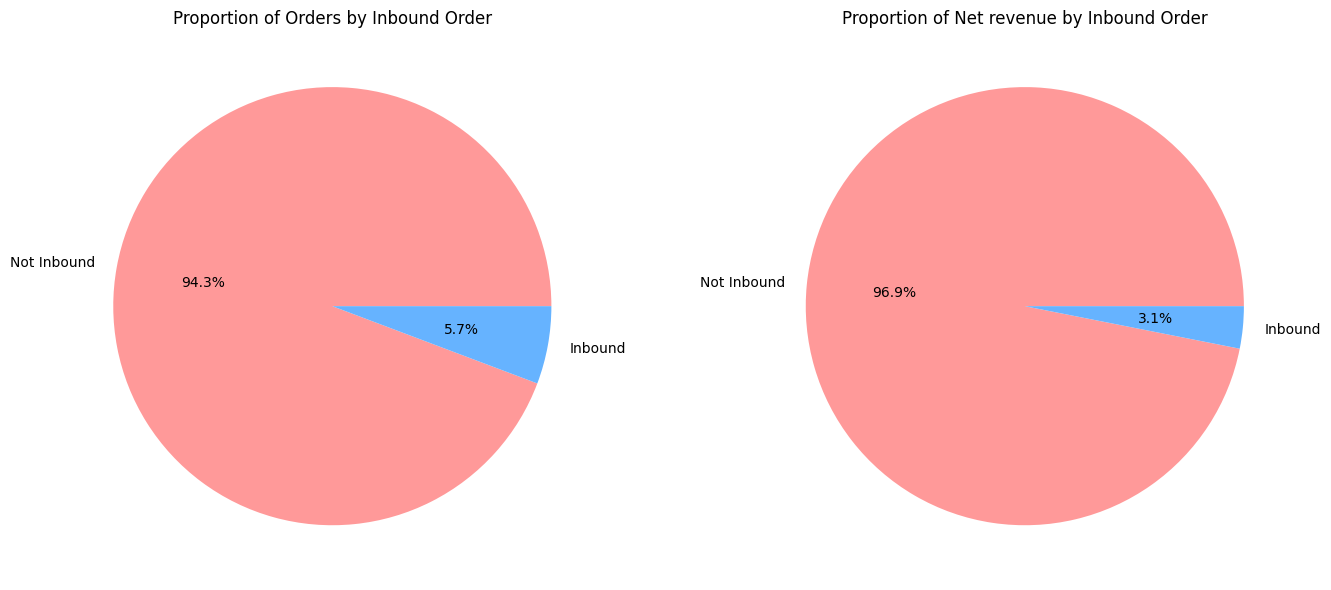

In [88]:
import matplotlib.pyplot as plt

# Plot two pie charts: one for inbound orders and one for non-inbound orders
plt.figure(figsize=(14, 6))

# Subplot 1: Pie chart for inbound orders
plt.subplot(1, 2, 1)
plt.pie(all_orders['inbound_order'].value_counts(), labels=['Not Inbound', 'Inbound'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Proportion of Orders by Inbound Order')

# Subplot 2: Pie chart for orders from inbound
plt.subplot(1, 2, 2)
margin_from_inbound = all_orders.groupby('flg_is_from_pro_form')['adjusted_net_revenue'].sum()
plt.pie(margin_from_inbound, labels=['Not Inbound', 'Inbound'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Proportion of Net revenue by Inbound Order')

# Show plot
plt.tight_layout()
plt.show()


In [90]:
all_orders

,pk_order,fk_seller,fk_opportunity,dt_checkout_date,cohort,ds_type_of_load,adjusted_gmv,adjusted_net_revenue,adjusted_contribution_margin,from_opp,pk_opportunity,flg_is_from_pro_form,inbound_order
0,a0b9N000000IgbtQAC,00109000009gnWVAAY,0069N000002RICGQA4,2023-01-02,2023-01-02,Mixed,8762.60,1655.24,155.24,True,NaN,False,False
1,a0b9N000000IpyNQAS,0010900000ivGnXAAU,NaN,2023-01-09,2023-01-09,Mixed,54872.75,5920.71,4289.26,False,NaN,False,False
2,a0b9N000000Isk8QAC,0019N000003MnlTQAS,0069N000002NWOpQAO,2023-01-10,2023-01-04,Mixed,18422.40,1696.80,446.80,True,NaN,False,False
3,a0b9N000000IxeGQAS,0019N000003JyMeQAK,0069N000002VXUiQAO,2023-01-12,2023-01-12,Mixed,39157.90,2030.08,1160.08,True,0069N000002VXUiQAO,False,False
4,a0b9N000000J6YgQAK,0010900000IKtPVAA1,0069N000002RG23QAG,2023-01-17,2023-01-17,Mixed,11079.00,1550.00,1300.00,True,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,a0b9N000000difzQAA,00109000009gqrFAAQ,NaN,2024-03-05,2023-01-13,Acquisition,NaN,NaN,NaN,False,NaN,False,False
1530,a0b9N000000dj7XQAQ,0019N000005ZC8AQAW,0069N000003QZBiQAO,2024-03-06,2024-01-24,Acquisition,NaN,NaN,NaN,True,0069N000003QZBiQAO,False,False
1531,a0b9N000000djUiQAI,00109000019J4cnAAC,0060900000LT9p2AAD,2024-03-07,2023-01-17,Stock transfer,0.00,0.00,0.00,True,NaN,False,False
1532,a0b9N000000dlDgQAI,00109000009gqrFAAQ,NaN,2024-03-13,2023-01-13,Acquisition,NaN,NaN,NaN,False,NaN,False,False


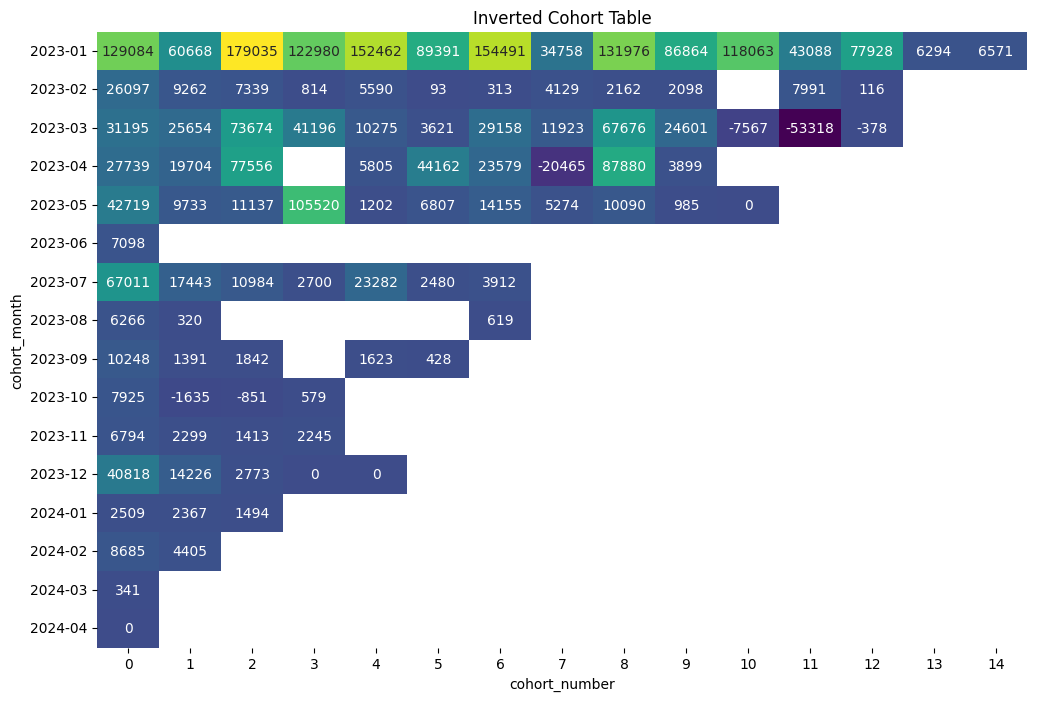

In [91]:
all_orders['cohort_number'] = (all_orders['dt_checkout_date'].dt.year - all_orders['cohort'].dt.year) * 12 \
                                 + (all_orders['dt_checkout_date'].dt.month - all_orders['cohort'].dt.month)


all_orders['cohort_month'] = all_orders['cohort'].dt.to_period('M')
# Plot inverted cohort table with color coding

# Create the pivot table
cohort_table = all_orders.pivot_table(index='cohort_month', columns='cohort_number', values='adjusted_contribution_margin', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, cmap='viridis', annot=True, fmt='.0f', cbar=False)

plt.title('Inverted Cohort Table')

plt.show()

In [92]:
# Show most negative orders

most_negative_orders = all_orders.nsmallest(10, 'adjusted_contribution_margin')

most_negative_orders

,pk_order,fk_seller,fk_opportunity,dt_checkout_date,cohort,ds_type_of_load,adjusted_gmv,adjusted_net_revenue,adjusted_contribution_margin,from_opp,pk_opportunity,flg_is_from_pro_form,inbound_order,cohort_number,cohort_month
99,a0b9N000000ddteQAA,0019N000004I0XRQA0,0069N000003ROfaQAG,2024-02-21,2023-03-21,Acquisition,5587.58,-50504.79,-51204.79,True,0069N000003ROfaQAG,False,False,11,2023-03
1429,a0b9N000000IwwvQAC,0019N000003JyMeQAK,0069N000002VfH2QAK,2023-01-12,2023-01-12,Acquisition,31606.40,-23937.76,-24874.82,True,0069N000002VfH2QAK,False,False,0,2023-01
1016,a0b9N000000ZYIJQA4,00109000009gqC9AAI,0069N000003IMMXQA4,2023-11-14,2023-04-04,Acquisition,22780.00,-20502.00,-21702.00,True,0069N000003IMMXQA4,False,False,7,2023-04
619,a0b9N000000RscxQAC,0010900000BUgbwAAD,NaN,2023-07-31,2023-07-31,Mixed,94122.00,12026.70,-13059.02,False,NaN,False,False,0,2023-07
1330,a0b9N000000JV0mQAG,0019N000003lqRUQAY,0069N000002YtNYQA0,2023-01-30,2023-01-16,Acquisition,27328.80,-11274.40,-11274.40,True,0069N000002YtNYQA0,False,False,0,2023-01
1451,a0b9N000000NP8oQAG,0019N000002ecj3QAA,0069N000002iKMCQA2,2023-04-06,2023-04-06,Acquisition,173376.00,-8107.98,-8107.98,True,0069N000002iKMCQA2,False,False,0,2023-04
1224,a0b9N000000clhhQAA,0019N000004I0XRQA0,0069N000003ROfaQAG,2024-01-16,2023-03-21,Acquisition,56503.00,-5869.42,-6649.42,True,0069N000003ROfaQAG,False,False,10,2023-03
1213,a0b9N000000ZNzjQAG,0019N000005MpqyQAC,0069N000003CO8WQAW,2023-11-09,2023-11-09,Acquisition,69834.80,694.40,-5846.15,True,0069N000003CO8WQAW,True,True,0,2023-11
1001,a0b9N000000SsVJQA0,00109000013Te7uAAC,0069N000002fxbVQAQ,2023-09-07,2023-01-17,Acquisition,180716.80,-5242.46,-5842.46,True,0069N000002fxbVQAQ,False,False,8,2023-01
44,a0b9N000000RbjUQAS,0019N000004FMv5QAG,0069N000002g6qnQAA,2023-07-21,2023-03-21,Mixed,4878.28,-4820.66,-5600.66,True,0069N000002g6qnQAA,False,False,4,2023-03


In [2]:
general_mql_events = pd.read_csv('data/general_mql_events.csv')


general_mql_events['dateHourMinute'] = pd.to_datetime(general_mql_events['dateHourMinute'], format='%Y%m%d%H%M')

# Localize the dateHourMinute column to the 'CET' timezone
general_mql_events['dateHourMinute'] = general_mql_events['dateHourMinute'].dt.tz_localize('CET')

# Convert the dateHourMinute column to its UTC equivalent
general_mql_events['dateHourMinute'] = general_mql_events['dateHourMinute'].dt.tz_convert('UTC')

general_mql_events.head()

,campaignId,campaignName,dateHourMinute,eventName,sessions
0,(not set),(referral),2023-02-02 14:55:00+00:00,general_mql,1
1,(not set),(referral),2023-02-03 14:29:00+00:00,general_mql,1
2,(not set),(referral),2023-02-04 13:16:00+00:00,general_mql,1
3,(not set),(referral),2023-02-05 14:09:00+00:00,general_mql,1
4,(not set),(referral),2023-02-05 14:10:00+00:00,general_mql,1


In [3]:
# Define events from search campaings
general_mql_from_campaign = general_mql_events[general_mql_events['campaignId'] != '(not set)']

# Print the results
general_mql_from_campaign.head()

,campaignId,campaignName,dateHourMinute,eventName,sessions
1181,17207660116,GER_Search_GEN,2023-02-13 00:36:00+00:00,general_mql,1
1182,17207660116,GER_Search_GEN,2023-02-15 11:22:00+00:00,general_mql,1
1183,17207660116,GER_Search_GEN,2023-02-18 01:08:00+00:00,general_mql,1
1184,17207660116,GER_Search_GEN,2023-02-20 08:43:00+00:00,general_mql,1
1185,17207660116,GER_Search_GEN,2023-02-28 11:07:00+00:00,general_mql,1


In [26]:
inbound_ops = pd.read_csv('data/inbound_opps.csv')

#Drop dco columns

dco_columns = [col for col in inbound_ops.columns if 'dco' in col]
inbound_ops.drop(columns=dco_columns, inplace=True)
inbound_ops.head()

,pk_opportunity,ds_stage_name,ds_type,ds_lead_source,ds_forecast_category,ds_forecast_category_name,ds_loss_reason,ds_transport_type,ds_contract_type,txt_description,...,ds_opportunity,fk_account,fk_record_type,fk_owner_user,fk_created_by_user,fk_last_modified_by_user,ts_created_at,ts_last_modified_at,cd_bo_id_unique_ext,flg_backoffice_did_this
0,0069N000002ZQI0QAO,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,pricing,NaN,NaN,NaN,...,R+G Metallbau Gmbh | Edelstahl - 1.4305 | 50 [t],0019N000003uleCQAQ,01209000000xizdAAA,0050900000Adq5kAAB,00509000001BCqYAAW,0050900000Adq5kAAB,2023-02-02 07:40:34.000000,2023-02-15 10:11:12.000000,2z2wKqfLYd83Yh8ZL,NaN
1,0069N000002ZVJEQA4,Closed Lost,NaN,Request to Buy Lead Form,Omitted,Omitted,lost,NaN,NaN,NaN,...,"privat | E1 - Eisen und Stahl, Mischschrott | ...",0019N000003uyagQAA,01209000000xizdAAA,0050900000Adq5kAAB,00509000001BCqYAAW,0050900000Adq5kAAB,2023-02-02 14:55:33.000000,2023-02-07 09:55:08.000000,D3GL3hpZnWy9EFG5h,NaN
2,0069N000002ZaniQAC,Closed Won,NaN,Request to Buy Lead Form,Closed,Closed,NaN,NaN,NaN,NaN,...,"Zwick Armaturen GmbH | HSS, gemischt, Schnella...",0019N000003vGPVQA2,01209000000xizdAAA,0050900000Adq5kAAB,00509000001BCqYAAW,00509000001BCqYAAW,2023-02-03 06:08:55.000000,2023-02-13 10:40:19.000000,k3HkQ5DBhhETyK9mL,NaN
3,0069N000002ZbY6QAK,To be Qualified,NaN,Request to Buy Lead Form,Pipeline,Pipeline,NaN,NaN,NaN,NaN,...,"Westfälischer Bau- und Abbruchservice GmbH, Wa...",0019N000003vI1uQAE,01209000000xizdAAA,00509000003YyhpAAC,00509000001BCqYAAW,0059N000000IAPEQA4,2023-02-03 07:57:55.000000,2023-05-12 12:22:42.000000,xNnKNARtNxJEQugzE,NaN
4,0069N000002ZcIFQA0,To be Qualified,NaN,Request to Buy Lead Form,Pipeline,Pipeline,NaN,NaN,NaN,NaN,...,Verleihservice Dennis Ulber | Geschirrzinn | 0...,0019N000003vJgwQAE,01209000000xizdAAA,00509000003YyhpAAC,00509000001BCqYAAW,0059N000000IAPEQA4,2023-02-03 09:08:21.000000,2023-05-12 12:22:42.000000,7kpbJWLJwKHMHanFr,NaN


In [30]:
unique_opps = inbound_ops[['pk_opportunity', 'ts_created_at']]
unique_opps['date'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.date
unique_opps['hour'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.hour
unique_opps['minute'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.minute

unique_opps.head()

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\285028814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_opps['date'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.date
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\285028814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_opps['hour'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.hour
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24

,pk_opportunity,ts_created_at,date,hour,minute
0,0069N000002ZQI0QAO,2023-02-02 07:40:34.000000,2023-02-02,7,40
1,0069N000002ZVJEQA4,2023-02-02 14:55:33.000000,2023-02-02,14,55
2,0069N000002ZaniQAC,2023-02-03 06:08:55.000000,2023-02-03,6,8
3,0069N000002ZbY6QAK,2023-02-03 07:57:55.000000,2023-02-03,7,57
4,0069N000002ZcIFQA0,2023-02-03 09:08:21.000000,2023-02-03,9,8


In [33]:
general_mql_from_campaign['date'] = general_mql_from_campaign['dateHourMinute'].dt.date
general_mql_from_campaign['hour'] = general_mql_from_campaign['dateHourMinute'].dt.hour
general_mql_from_campaign['minute'] = general_mql_from_campaign['dateHourMinute'].dt.minute

general_mql_from_campaign.head()

#Match the two dataframes on date, hour and minute
merged = pd.merge(general_mql_from_campaign, unique_opps, how='inner', on=['date', 'hour', 'minute'])

len(merged)

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\665334933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['date'] = general_mql_from_campaign['dateHourMinute'].dt.date
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\665334933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['hour'] = general_mql_from_campaign['dateHourMinute'].dt.hour
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\665334933.py:3: SettingWit

78

Only 78 matches by the minute. Let's create a function that matches the date on the next n minutes (considering delays in the sync might occur)

In [61]:
general_mql_from_campaign['datetime']

1181   2023-02-13 00:36:00+00:00
1182   2023-02-15 11:22:00+00:00
1183   2023-02-18 01:08:00+00:00
1184   2023-02-20 08:43:00+00:00
1185   2023-02-28 11:07:00+00:00
                  ...           
1390   2024-03-31 07:21:00+00:00
1391   2024-04-01 14:16:00+00:00
1392   2024-03-07 12:58:00+00:00
1393   2024-03-08 09:24:00+00:00
1394   2024-03-11 11:40:00+00:00
Name: datetime, Length: 214, dtype: datetime64[ns, UTC]

In [60]:
inbound_ops['datetime'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S')

general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S', utc=False)


C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\894447432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S', utc=False)


In [81]:
inbound_ops['datetime'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S')

general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S')

# Remove the time zone information
inbound_ops['datetime'] = inbound_ops['datetime'].dt.tz_localize(None)
general_mql_from_campaign['datetime'] = general_mql_from_campaign['datetime'].dt.tz_localize(None)

tolerance = 7

merged_df = pd.merge_asof(general_mql_from_campaign.sort_values('datetime'), inbound_ops.sort_values('datetime'), 
                          on='datetime', tolerance=pd.Timedelta(minutes=tolerance), direction='nearest')

len(merged_df['pk_opportunity'].unique())

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\1021937135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S')
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\1021937135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = general_mql_from_campaign['datetime'].dt.tz_localize(None)


100

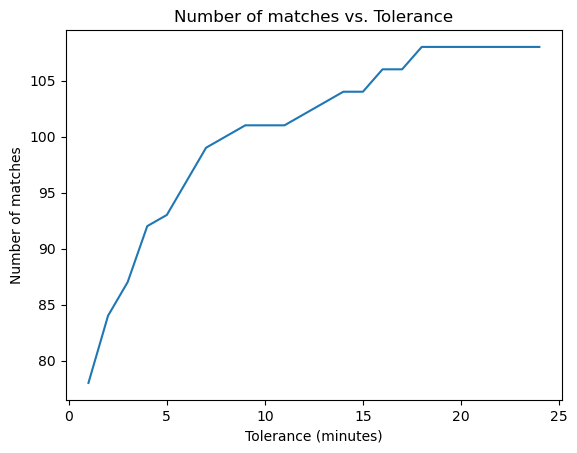

In [82]:
import matplotlib.pyplot as plt 
number_matches = []
for tolerance in range(1, 25):
    merged_df = pd.merge_asof(general_mql_from_campaign.sort_values('datetime'), inbound_ops.sort_values('datetime'), 
                            on='datetime', tolerance=pd.Timedelta(minutes=tolerance), direction='nearest')

    number_matches.append(len(merged_df['pk_opportunity'].unique())-1)

plt.plot(range(1, 25), number_matches)

plt.xlabel('Tolerance (minutes)')
plt.ylabel('Number of matches')
plt.title('Number of matches vs. Tolerance')

plt.show()


With that in mind, we keep the tolerance at 10 minutes

In [83]:
inbound_ops['datetime'] = pd.to_datetime(inbound_ops['ts_created_at'], format='%Y-%m-%d %H:%M:%S')

general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S')

# Remove the time zone information
inbound_ops['datetime'] = inbound_ops['datetime'].dt.tz_localize(None)
general_mql_from_campaign['datetime'] = general_mql_from_campaign['datetime'].dt.tz_localize(None)

tolerance = 10

merged_df = pd.merge_asof(general_mql_from_campaign.sort_values('datetime'), inbound_ops.sort_values('datetime'), 
                          on='datetime', tolerance=pd.Timedelta(minutes=tolerance), direction='nearest')

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\2638138347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S')
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_24084\2638138347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = general_mql_from_campaign['datetime'].dt.tz_localize(None)


102

In [89]:
inbound_opps_sae = merged_df[~merged_df['pk_opportunity'].isna()]

Next, let's look simply at the revenue generated from these opportunities directly (i.e: from the orders generated from them). We will look at the total LTV of these customers.

In [23]:
# Connect to Databricks
from databricks import sql
import os
from dotenv import load_dotenv

# Load the environment variables
load_dotenv()

# Set the connection
connection =  sql.connect(server_hostname = os.getenv("DATABRICKS_SERVER_HOSTNAME"),
                 http_path       = os.getenv("DATABRICKS_HTTP_PATH"),
                 access_token    = os.getenv("PYTHON_ACCESS_TOKEN"))

cursor = connection.cursor()


In [28]:
# query to create a table with the data

query = \
    """
with wholesale_orders as (
    select * from prd.silver.stg_salesforce__order
    where ds_order_status in ('completed', 'buffer')
    and ds_order_record_type != '01209000000xizfAAA'
    and dt_checkout_date >= '2023-01-01'
)

, first_order as (
    select
        fk_seller,
        pk_order,
        dt_checkout_date,
        rank() over(partition by fk_seller order by dt_checkout_date) as order_rank
    from wholesale_orders
    order by fk_seller, order_rank
)


-- GET THE CART ITEM VALUES TO CALCUATE THE STOCK CORRECTIONS
, cart_items as (
    select
        fk_order
        , sum(vl_sale_fifo_out * vl_quantity_purchase) as acquisition_gmv_correction
        , sum(vl_purchase_fifo_out * cast(vl_quantity_sell as numeric(16,2))) as liquidation_nr_correction
        -- FLAG IF THE CORRECTIONS ARE COMPLETE OR NOT
        , sum(case when vl_sale_fifo_out is not null then 1 else 0 end) / count(*) as acquisition_completed_perc
        , sum(case when vl_purchase_fifo_out is not null then 1 else 0 end)/count(*) as liquidation_completed_perc
    from prd.silver.stg_salesforce__cart_item
    where fk_order in (select pk_order from wholesale_orders)
    group by fk_order
)

-- JOIN THE STOCK CORRECTED VALUES INTO THE ORDER
, stock_corrected_order as (
    select 
        *
    from wholesale_orders
    left join cart_items
    on wholesale_orders.pk_order = cart_items.fk_order
)

, sellers as (
    select 
      distinct fk_seller 
      , min(dt_checkout_date) as cohort
    from first_order
    where order_rank = 1
    group by fk_seller
)

, join_seller_cohort as (
    select
        pk_order
        , fk_opportunity
        , stock_corrected_order.fk_seller
        , dt_checkout_date
        , cohort
        , ds_type_of_load
        , acquisition_gmv_correction
        , acquisition_completed_perc
        , vl_gmv
        , vl_gross_margin
        , liquidation_nr_correction
        , liquidation_completed_perc
        , vl_total_margin
        , cohort
    from stock_corrected_order
    left join sellers
    on stock_corrected_order.fk_seller = sellers.fk_seller
)

, stock_corrected as (
    select
        pk_order
        , fk_seller
        , fk_opportunity
        , dt_checkout_date
        , cohort
        , ds_type_of_load
        , acquisition_completed_perc
        , liquidation_completed_perc
        , case 
            when ds_type_of_load = "Acquisition"
                then acquisition_gmv_correction
            else
                vl_gmv
        end as adjusted_gmv
        , case 
            when ds_type_of_load = "Acquisition"
                then acquisition_gmv_correction + vl_gross_margin
            when ds_type_of_load = "Liquidation"
                then vl_gross_margin - liquidation_nr_correction
            else
                vl_gross_margin
        end as adjusted_net_revenue
        , case 
            when ds_type_of_load = "Acquisition"
                then acquisition_gmv_correction + vl_total_margin
            when ds_type_of_load = "Liquidation"
                then vl_total_margin - liquidation_nr_correction
            else
                vl_total_margin
        end as adjusted_contribution_margin
    from join_seller_cohort
)

, final (
    select 
        *
    from stock_corrected
    where 
        (ds_type_of_load = 'Acquisition' and acquisition_completed_perc = 1)
        or ds_type_of_load = 'Mixed'
)

select * from final
order by adjusted_contribution_margin

"""

# Execute the query
cursor.execute(query)

inbound_adjusted_orders = cursor.fetchall()


In [29]:
# Start spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("mkt_analysis_2024") \
    .getOrCreate()

# Convert the list of Rows to a DataFrame
df = spark.createDataFrame(inbound_adjusted_orders)

# Convert Spark DataFrame to Pandas DataFrame
inbound_adjusted_orders_df = df.toPandas()


In [30]:
inbound_adjusted_orders_df.head()


,pk_order,fk_seller,fk_opportunity,dt_checkout_date,cohort,ds_type_of_load,acquisition_completed_perc,liquidation_completed_perc,adjusted_gmv,adjusted_net_revenue,adjusted_contribution_margin
0,a0b9N000000IwwvQAC,0019N000003JyMeQAK,0069N000002VfH2QAK,2023-01-12,2023-01-12,Acquisition,1.0,0.0,31606.400000000000000000,-23937.760000000000000000,-24874.820000000000000000
1,a0b9N000000ZYIJQA4,00109000009gqC9AAI,0069N000003IMMXQA4,2023-11-14,2023-04-04,Acquisition,1.0,0.0,22780.000000000000000000,-20502.000000000000000000,-21702.000000000000000000
2,a0b9N000000RscxQAC,0010900000BUgbwAAD,None,2023-07-31,2023-07-31,Mixed,0.0,0.0,94122.000000000000000000,12026.700000000000000000,-13059.020000000000000000
3,a0b9N000000NP8oQAG,0019N000002ecj3QAA,0069N000002iKMCQA2,2023-04-06,2023-04-06,Acquisition,1.0,0.0,173376.000000000000000000,-8107.980000000000000000,-8107.980000000000000000
4,a0b9N000000clhhQAA,0019N000004I0XRQA0,0069N000003ROfaQAG,2024-01-16,2023-03-21,Acquisition,1.0,0.0,56503.000000000000000000,-5869.420000000000000000,-6649.420000000000000000


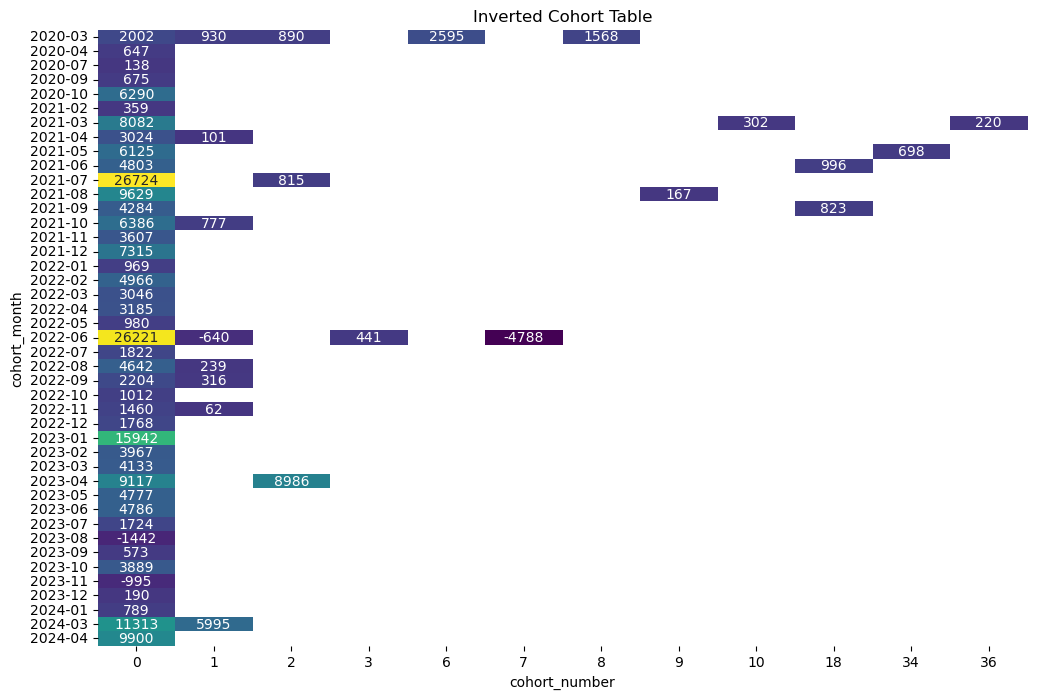

In [24]:
import pandas as pd
inbound_orders = pd.read_csv('data/inbound_orders_2024_04_04.csv')

# Transform date types
inbound_orders['order_date'] = pd.to_datetime(inbound_orders['dt_checkout_date'], format='%Y-%m-%d')
inbound_orders['cohort'] = pd.to_datetime(inbound_orders['cohort'], format='%Y-%m-%d')

# Get month difference betwee checkout date and cohort

inbound_orders['cohort_number'] = (inbound_orders['order_date'].dt.year - inbound_orders['cohort'].dt.year) * 12 \
                                 + (inbound_orders['order_date'].dt.month - inbound_orders['cohort'].dt.month)


inbound_orders['cohort_month'] = inbound_orders['cohort'].dt.to_period('M')
# Plot inverted cohort table with color coding

import seaborn as sns
import matplotlib.pyplot as plt

# Create the pivot table

cohort_table = inbound_orders.pivot_table(index='cohort_month', columns='cohort_number', values='adjusted_contribution_margin', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, cmap='viridis', annot=True, fmt='.0f', cbar=False)

plt.title('Inverted Cohort Table')

plt.show()


In the interest of time and 

with inbound_ops as (
    select * from prd.silver.stg_salesforce__opportunity
    where flg_is_from_pro_form = true
    and (ds_loss_reason != 'fake' or ds_loss_reason is null)
)

, inbound_orders as (
    select * from prd.silver.stg_salesforce__order
    where fk_opportunity in (select pk_opportunity from inbound_ops as)
)

, first_order as (
    select
        fk_seller,
        pk_order,
        dt_checkout_date,
        rank() over(partition by fk_seller order by dt_checkout_date) as order_rank
    from prd.silver.stg_salesforce__order
    where fk_seller is not null
    and ds_order_status not in ('test', 'canceled', 'failed')
    and pk_order in (select pk_order from inbound_orders)
    order by fk_seller, order_rank
)

, inbound_sellers as (
    select 
      distinct fk_seller 
      , min(dt_checkout_date) as cohort
    from first_order
    where order_rank = 1
    group by fk_seller
)

select * from inbound_sellers

True

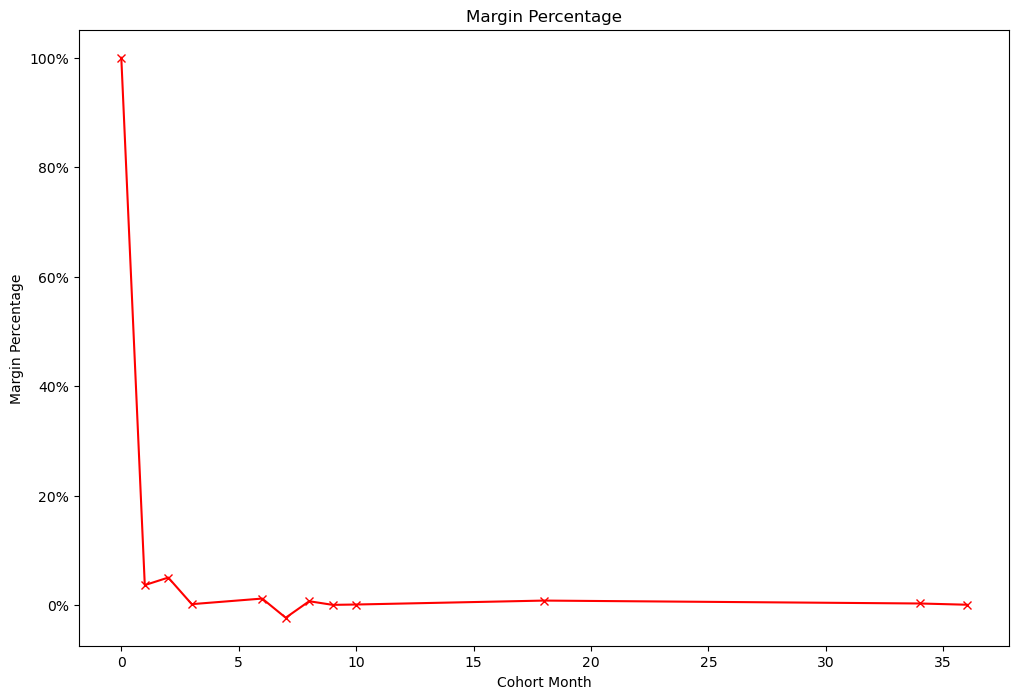

In [38]:
# CAlculate the total margin per cohort month
total_margin = cohort_table.sum(axis=0)

# Calculate the percentage of the previous month's margin (with the first month being 100%)

margin_percentage_mom = total_margin / total_margin.shift(1)

# Calculate the percentage of the first month's margin (with the first month being 100%)

margin_percentage_first = total_margin / total_margin.iloc[0]

# Plot the margin percentage

plt.figure(figsize=(12, 8))


# plt.twinx()
# # Plot the margin percentage
# plt.plot(margin_percentage_mom.index, margin_percentage_mom.values, marker='o')
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
# PLot the margin percentage of first in a second axis
plt.plot(margin_percentage_first.index, margin_percentage_first.values, marker='x', color='red')

# Both y axis in percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Add labels
plt.title('Margin Percentage')
plt.xlabel('Cohort Month')
plt.ylabel('Margin Percentage')

plt.show()

There is basically no retention. That is, the inbound channel is almost exclusevily spot business

In [44]:
total_return = inbound_orders[inbound_orders['cohort_month'] >= '2023-02']['adjusted_contribution_margin'].sum()

total_costs = 46659.77

roi = total_return / total_costs

roi

1.4509651462062505

So there is indeed a postive ROI, however, here we took all of the inbound orders (from organic or paid searches) as the return. We could make the argument that all of the marketing inbound efforts, including the ones that don't lead to a sale, contribute to this result. Nevertheless, will now repeat the analssis for the sellers that came (at first) from inbound (or at least we can make an attritbution)

In [1]:
import pandas as pd